In [16]:
# CELL 1: Imports and Setup
#
# Description: This cell imports all necessary libraries and our custom model files.
# It also sets up the device (your Apple Metal GPU) and defines some basic parameters.
#

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os

# Import our custom classes and functions
from models import Generator
from encoder import FaceNetEncoder
from dataLoaders import get_dataloaders

# --- Configuration ---
CHECKPOINT_EPOCH = 20
CHECKPOINT_DIR = "./checkpoints_widerface"
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{CHECKPOINT_EPOCH}.pth")
BATCH_SIZE = 16 # How many images to display
IMAGE_SIZE = 128
NOISE_DIM = 100
EMBEDDING_DIM = 512

# Set the device to Apple Metal GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [17]:
# CELL 2: Load the Trained Models
#
# Description: This cell instantiates the Generator and Encoder models and then
# loads the saved weights from your epoch 20 checkpoint into the Generator.
# Both models are set to evaluation mode to disable things like dropout.
#

# --- Initialize Encoder ---
print("Loading FaceNet Encoder...")
encoder = FaceNetEncoder(device=device)
encoder.eval() # Set to evaluation mode

# --- Initialize and Load Generator ---
print(f"Loading Generator from epoch {CHECKPOINT_EPOCH}...")
generator = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)

# Load the saved state dictionary
try:
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    print("Generator weights loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Checkpoint file not found at '{GENERATOR_PATH}'")
    print("Please make sure the checkpoint from your training run exists.")

generator.eval() # Set to evaluation mode

Loading FaceNet Encoder...
Loading Generator from epoch 20...
Generator weights loaded successfully.


Generator(
  (init_block): Sequential(
    (0): ConvTranspose2d(612, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [18]:
# CELL 3: Load the Unseen Test Data
#
# Description: We use our get_dataloaders function to get the test data loader.
# Then, we fetch a single batch of real images to use for inference.
#

print("Loading test dataset...")
# We only need the test_loader for inference
_, test_loader = get_dataloaders(data_root='.', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

# Get one batch of real images from the test set
if test_loader:
    real_images, _ = next(iter(test_loader))
    real_images = real_images.to(device)
    print(f"Loaded a batch of {real_images.size(0)} real test images.")
else:
    print("Could not load test data.")
    real_images = None

Loading test dataset...
Loading training data from: ./data/train
Loading test data from: ./data/test

DataLoaders created successfully!
Number of training images: 10000
Number of testing images: 500
Loaded a batch of 16 real test images.


In [19]:
# CELL 4: Generate New Faces
#
# Description: This is the core inference step.
# 1. We get the "identity fingerprints" (embeddings) from the real images.
# 2. We create random noise.
# 3. We feed the noise and the embeddings into our trained Generator to create new images.
#

if real_images is not None:
    with torch.no_grad():
        # 1. Get the embeddings from the real images
        print("Generating embeddings from real images...")
        real_embeddings = encoder(real_images)

        # 2. Create random noise
        print("Creating random noise vector...")
        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)

        # 3. Generate fake images using the embeddings and noise
        print("Generating new faces with the Generator...")
        generated_images = generator(noise, real_embeddings).detach().cpu()
    print("Inference complete.")

Generating embeddings from real images...
Creating random noise vector...
Generating new faces with the Generator...
Inference complete.


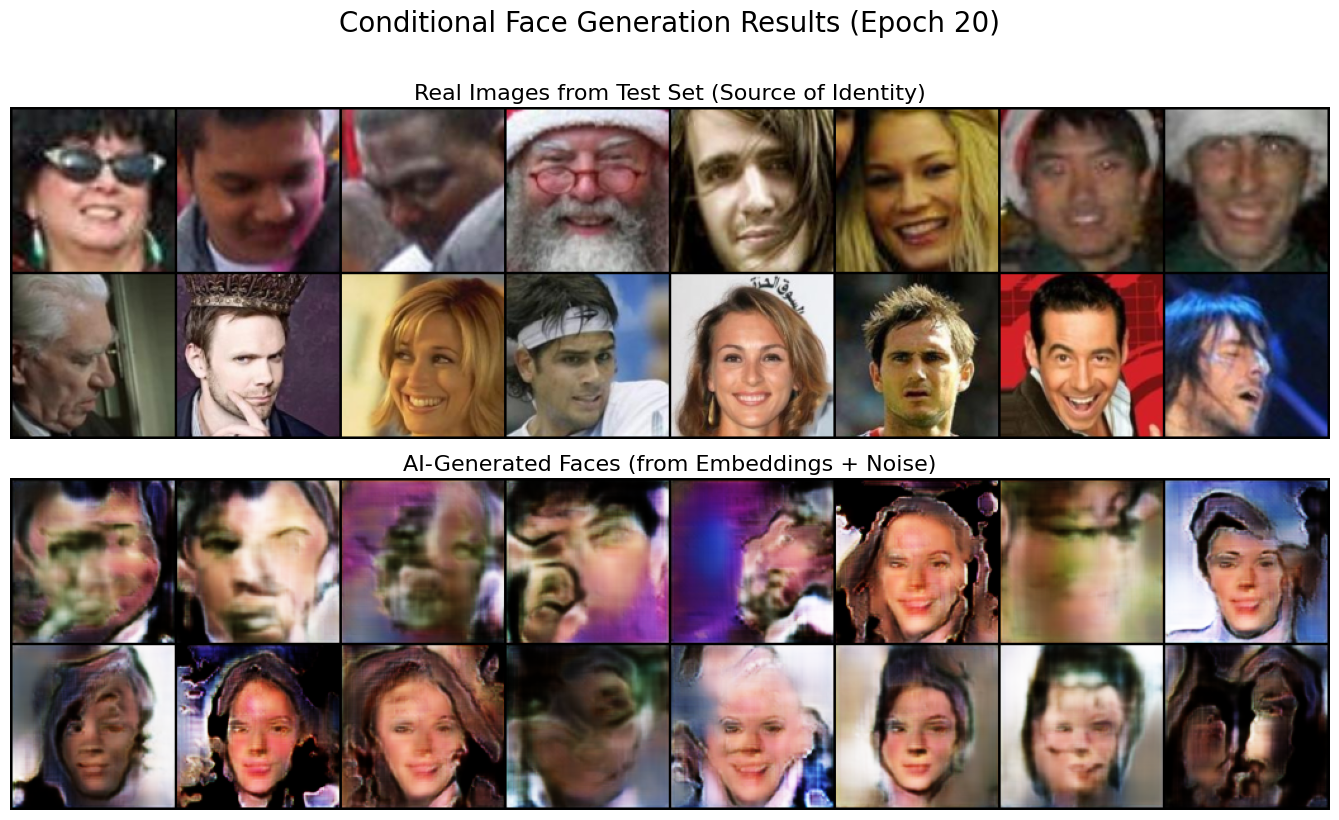

In [20]:
# CELL 5: Visualize and Compare the Results
#
# Description: This cell displays the original test images and the newly generated
# faces side-by-side for a clear visual comparison.
#

def un_normalize(tensor):
    """Reverses the ToTensor normalization to display images correctly."""
    return tensor * 0.5 + 0.5

if 'generated_images' in locals():
    # Prepare images for plotting
    real_grid = make_grid(un_normalize(real_images.cpu()), nrow=8)
    generated_grid = make_grid(un_normalize(generated_images), nrow=8)

    # Plot the images
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))
    fig.suptitle('Conditional Face Generation Results (Epoch 20)', fontsize=20, y=1.02)
    
    ax[0].imshow(np.transpose(real_grid, (1, 2, 0)))
    ax[0].set_title("Real Images from Test Set (Source of Identity)", fontsize=16)
    ax[0].axis('off')

    ax[1].imshow(np.transpose(generated_grid, (1, 2, 0)))
    ax[1].set_title("AI-Generated Faces (from Embeddings + Noise)", fontsize=16)
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()